# Milestone 3 - Second Model II

In [1]:
# imports 
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from second_scripts import *
from scripts import *

### I. Data Prepration

In [2]:
# Read the data
# data_path = './data'
data_path = './DLCV_SS25_Dataset'  
images, labels = data_reader2(data_path)


In [3]:
num_classes = len(os.listdir(data_path))
num_classes

5

In [4]:
len(images)

2351

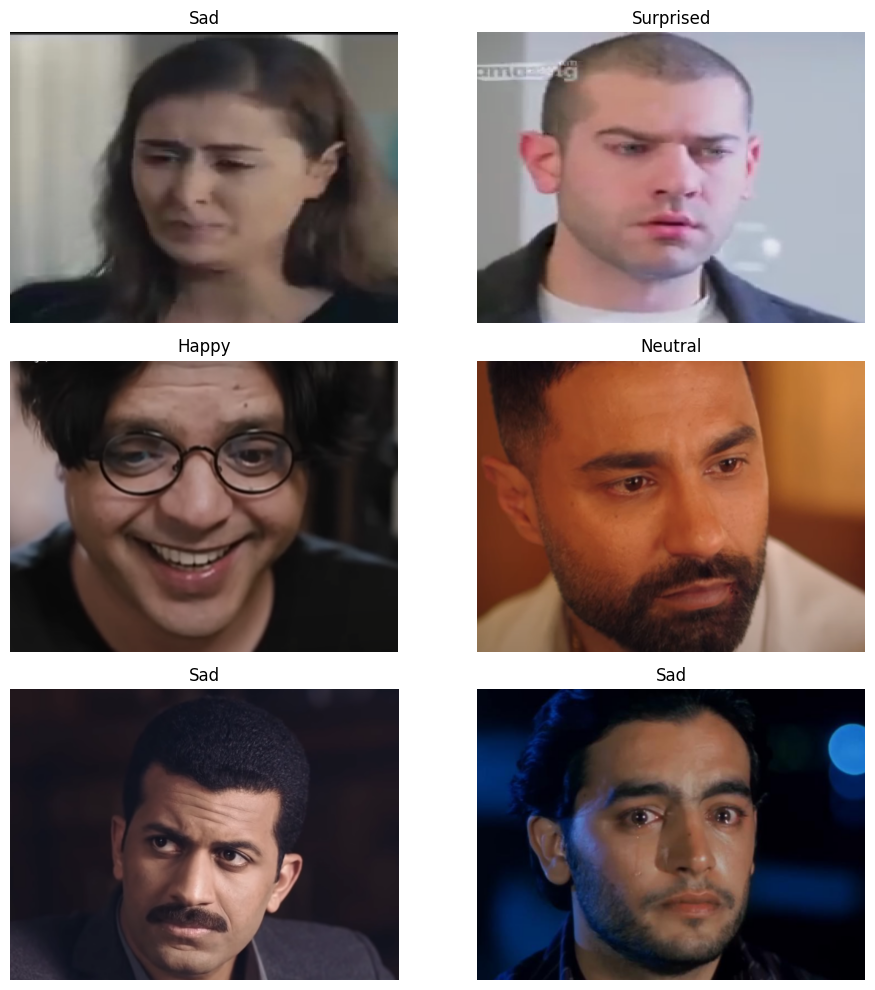

In [5]:
# View 4 random images and their titles
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(images))
    ax.imshow(images[idx])
    ax.set_title(labels[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Preprocess the images 
train_tuple, val_tuple, test_tuple, label_to_index = data_preperator2((images, labels))
index_to_label = {v: k for k, v in label_to_index.items()}

train_data, train_labels = train_tuple
val_data, val_labels = val_tuple
test_data, test_labels = test_tuple

train_data.shape, train_labels.shape, val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((1645, 512, 512, 3),
 (1645,),
 (470, 512, 512, 3),
 (470,),
 (236, 512, 512, 3),
 (236,))

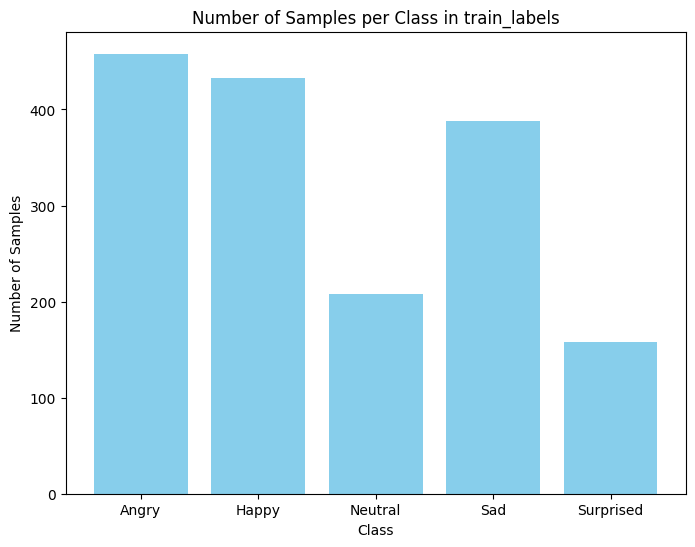

In [7]:
draw_barchart_labels(train_labels, label_to_index)

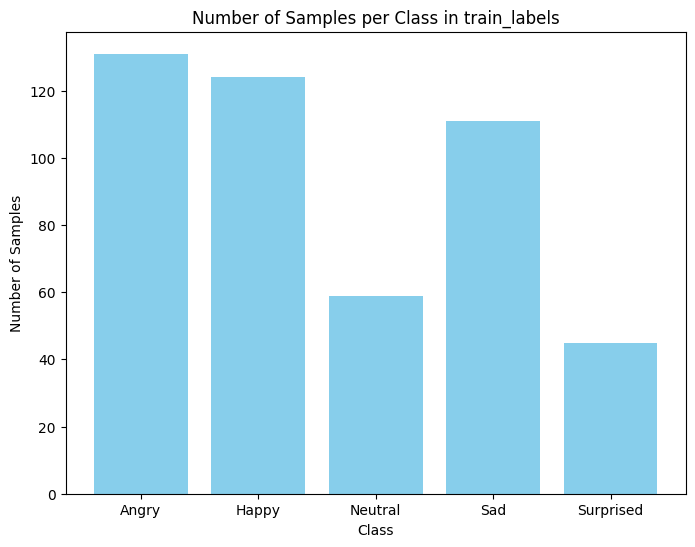

In [8]:
draw_barchart_labels(val_labels, label_to_index)

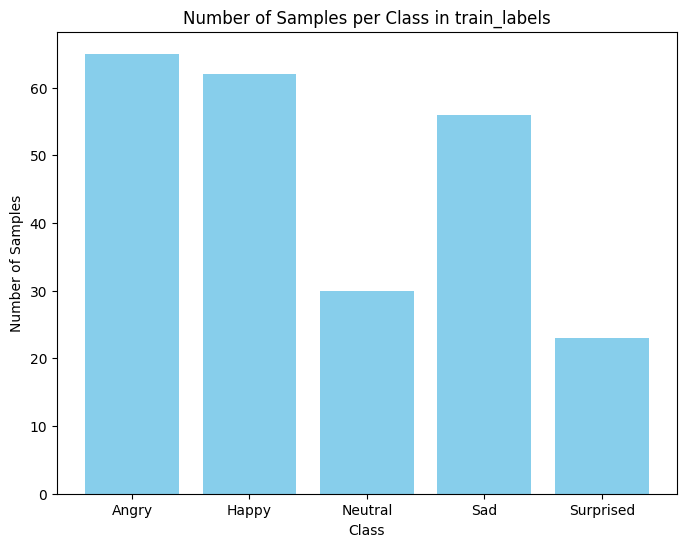

In [9]:
draw_barchart_labels(test_labels, label_to_index)

### II. Second Model

In [10]:
train_loader = convert_to_dataloader(data=(train_data, train_labels), batch_size=16, shuffle=True)
val_loader = convert_to_dataloader(data=(val_data, val_labels), batch_size=16, shuffle=False)
test_loader = convert_to_dataloader(data=(test_data, test_labels), batch_size=16, shuffle=False)

In [11]:
second_model = SecondModel3()
summary(second_model, input_size=(3, 512, 512), batch_size=1, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 32, 510, 510]             896
            Conv2d-2          [1, 32, 508, 508]           9,248
            Conv2d-3          [1, 32, 506, 506]           9,248
              ReLU-4          [1, 32, 506, 506]               0
         MaxPool2d-5          [1, 32, 253, 253]               0
       BatchNorm2d-6          [1, 32, 253, 253]              64
         CNNBlock2-7          [1, 32, 253, 253]               0
            Conv2d-8          [1, 64, 251, 251]          18,496
            Conv2d-9          [1, 64, 249, 249]          36,928
           Conv2d-10          [1, 64, 247, 247]          36,928
             ReLU-11          [1, 64, 247, 247]               0
        MaxPool2d-12          [1, 64, 123, 123]               0
      BatchNorm2d-13          [1, 64, 123, 123]             128
        CNNBlock2-14          [1, 64, 1

In [12]:
from torch.utils.data import ConcatDataset
cross_validate_train_ds = ConcatDataset([train_loader.dataset, val_loader.dataset])

fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies, best_model = cross_validate(
                                                                                                train_ds=cross_validate_train_ds,
                                                                                                model_fn=SecondModel3,
                                                                                                k=5,
                                                                                                stratified=True,
                                                                                                num_epochs=10,
                                                                                                batch_size=16,
                                                                                                num_workers=4,
                                                                                                lr= 1e-3,
                                                                                                random_state= 42)


--- Fold 1/5 ---


Epoch [1/10]


train_Loss: 1.5297  train_Acc: 0.2849  train_Prec: 0.1086  train_Rec: 0.2074  train_F1: 0.1356  train_ROC-AUC: 0.5402


val_Loss: 1.5361  val_Acc: 0.2766  val_Prec: 0.1027  val_Rec: 0.2002  val_F1: 0.1267  val_ROC-AUC: 0.5336
--------------------------------------------------


Epoch [2/10]


train_Loss: 1.5138  train_Acc: 0.3310  train_Prec: 0.2115  train_Rec: 0.2477  train_F1: 0.2038  train_ROC-AUC: 0.6077


val_Loss: 1.5047  val_Acc: 0.3546  val_Prec: 0.2370  val_Rec: 0.2655  val_F1: 0.2286  val_ROC-AUC: 0.6003
--------------------------------------------------


Epoch [3/10]


train_Loss: 1.4923  train_Acc: 0.3310  train_Prec: 0.1691  train_Rec: 0.2457  train_F1: 0.1732  train_ROC-AUC: 0.6128


val_Loss: 1.4983  val_Acc: 0.3475  val_Prec: 0.2057  val_Rec: 0.2564  val_F1: 0.1835  val_ROC-AUC: 0.5903
--------------------------------------------------


Epoch [4/10]


train_Loss: 1.4846  train_Acc: 0.3712  train_Prec: 0.2493  train_Rec: 0.2845  train_F1: 0.2439  train_ROC-AUC: 0.6498


val_Loss: 1.5010  val_Acc: 0.3783  val_Prec: 0.2546  val_Rec: 0.2901  val_F1: 0.2460  val_ROC-AUC: 0.6252
--------------------------------------------------


Epoch [5/10]


train_Loss: 1.4550  train_Acc: 0.3617  train_Prec: 0.3190  train_Rec: 0.2694  train_F1: 0.2227  train_ROC-AUC: 0.6521


val_Loss: 1.4624  val_Acc: 0.3664  val_Prec: 0.2297  val_Rec: 0.2714  val_F1: 0.2234  val_ROC-AUC: 0.6456
--------------------------------------------------


Epoch [6/10]


train_Loss: 1.5112  train_Acc: 0.3375  train_Prec: 0.2875  train_Rec: 0.2611  train_F1: 0.2261  train_ROC-AUC: 0.6472


val_Loss: 1.5173  val_Acc: 0.3522  val_Prec: 0.3141  val_Rec: 0.2706  val_F1: 0.2358  val_ROC-AUC: 0.6190
--------------------------------------------------


Epoch [7/10]


train_Loss: 1.4349  train_Acc: 0.3747  train_Prec: 0.2235  train_Rec: 0.2828  train_F1: 0.2325  train_ROC-AUC: 0.6763


val_Loss: 1.4430  val_Acc: 0.3948  val_Prec: 0.2463  val_Rec: 0.2972  val_F1: 0.2487  val_ROC-AUC: 0.6716
--------------------------------------------------


Epoch [8/10]


train_Loss: 1.4246  train_Acc: 0.3972  train_Prec: 0.2348  train_Rec: 0.3021  train_F1: 0.2618  train_ROC-AUC: 0.6713


val_Loss: 1.4192  val_Acc: 0.3924  val_Prec: 0.2314  val_Rec: 0.2967  val_F1: 0.2588  val_ROC-AUC: 0.6513
--------------------------------------------------


Epoch [9/10]


train_Loss: 1.3794  train_Acc: 0.4196  train_Prec: 0.2465  train_Rec: 0.3204  train_F1: 0.2762  train_ROC-AUC: 0.7028


val_Loss: 1.4204  val_Acc: 0.3972  val_Prec: 0.2361  val_Rec: 0.3022  val_F1: 0.2631  val_ROC-AUC: 0.6671
--------------------------------------------------


Epoch [10/10]


train_Loss: 1.3626  train_Acc: 0.4332  train_Prec: 0.2561  train_Rec: 0.3292  train_F1: 0.2815  train_ROC-AUC: 0.7178


val_Loss: 1.4052  val_Acc: 0.4374  val_Prec: 0.2594  val_Rec: 0.3312  val_F1: 0.2866  val_ROC-AUC: 0.6736
--------------------------------------------------
Fold 1 val accuracy: 0.4374

--- Fold 2/5 ---


Epoch [1/10]


train_Loss: 1.5586  train_Acc: 0.3091  train_Prec: 0.2190  train_Rec: 0.2341  train_F1: 0.1577  train_ROC-AUC: 0.5919


val_Loss: 1.6109  val_Acc: 0.2742  val_Prec: 0.1800  val_Rec: 0.2081  val_F1: 0.1338  val_ROC-AUC: 0.5404
--------------------------------------------------


Epoch [2/10]


train_Loss: 1.5109  train_Acc: 0.3369  train_Prec: 0.2283  train_Rec: 0.2494  train_F1: 0.1861  train_ROC-AUC: 0.6068


val_Loss: 1.5593  val_Acc: 0.3097  val_Prec: 0.2545  val_Rec: 0.2290  val_F1: 0.1715  val_ROC-AUC: 0.5426
--------------------------------------------------


Epoch [3/10]


train_Loss: 1.5244  train_Acc: 0.3038  train_Prec: 0.2279  train_Rec: 0.2406  train_F1: 0.1894  train_ROC-AUC: 0.6009


val_Loss: 1.5160  val_Acc: 0.3168  val_Prec: 0.2139  val_Rec: 0.2482  val_F1: 0.1986  val_ROC-AUC: 0.6160
--------------------------------------------------


Epoch [4/10]


train_Loss: 1.4327  train_Acc: 0.3800  train_Prec: 0.2720  train_Rec: 0.2873  train_F1: 0.2449  train_ROC-AUC: 0.6682


val_Loss: 1.5084  val_Acc: 0.3522  val_Prec: 0.2140  val_Rec: 0.2667  val_F1: 0.2276  val_ROC-AUC: 0.5938
--------------------------------------------------


Epoch [5/10]


train_Loss: 1.4419  train_Acc: 0.3848  train_Prec: 0.2796  train_Rec: 0.2936  train_F1: 0.2602  train_ROC-AUC: 0.6624


val_Loss: 1.5169  val_Acc: 0.3641  val_Prec: 0.2203  val_Rec: 0.2765  val_F1: 0.2415  val_ROC-AUC: 0.5935
--------------------------------------------------


Epoch [6/10]


train_Loss: 1.4319  train_Acc: 0.3859  train_Prec: 0.3227  train_Rec: 0.3025  train_F1: 0.2830  train_ROC-AUC: 0.6705


val_Loss: 1.4994  val_Acc: 0.3759  val_Prec: 0.3114  val_Rec: 0.2905  val_F1: 0.2655  val_ROC-AUC: 0.6054
--------------------------------------------------


Epoch [7/10]


train_Loss: 1.4241  train_Acc: 0.3883  train_Prec: 0.2332  train_Rec: 0.2935  train_F1: 0.2544  train_ROC-AUC: 0.6676


val_Loss: 1.5143  val_Acc: 0.3593  val_Prec: 0.2193  val_Rec: 0.2726  val_F1: 0.2367  val_ROC-AUC: 0.6064
--------------------------------------------------


Epoch [8/10]


train_Loss: 1.5697  train_Acc: 0.3115  train_Prec: 0.3094  train_Rec: 0.2389  train_F1: 0.1687  train_ROC-AUC: 0.6554


val_Loss: 1.6627  val_Acc: 0.2837  val_Prec: 0.1926  val_Rec: 0.2164  val_F1: 0.1373  val_ROC-AUC: 0.5746
--------------------------------------------------


Epoch [9/10]


train_Loss: 1.3979  train_Acc: 0.4060  train_Prec: 0.3531  train_Rec: 0.3269  train_F1: 0.3042  train_ROC-AUC: 0.7042


val_Loss: 1.4876  val_Acc: 0.3546  val_Prec: 0.2560  val_Rec: 0.2803  val_F1: 0.2474  val_ROC-AUC: 0.6180
--------------------------------------------------


Epoch [10/10]


train_Loss: 1.3723  train_Acc: 0.4178  train_Prec: 0.3386  train_Rec: 0.3269  train_F1: 0.3007  train_ROC-AUC: 0.7061


val_Loss: 1.4755  val_Acc: 0.3735  val_Prec: 0.2728  val_Rec: 0.2885  val_F1: 0.2566  val_ROC-AUC: 0.6271
--------------------------------------------------
Fold 2 val accuracy: 0.3735

--- Fold 3/5 ---


Epoch [1/10]


train_Loss: 1.4877  train_Acc: 0.3245  train_Prec: 0.1978  train_Rec: 0.2429  train_F1: 0.1807  train_ROC-AUC: 0.6256


val_Loss: 1.4754  val_Acc: 0.3664  val_Prec: 0.2466  val_Rec: 0.2758  val_F1: 0.2103  val_ROC-AUC: 0.6279
--------------------------------------------------


Epoch [2/10]


train_Loss: 1.4758  train_Acc: 0.3416  train_Prec: 0.2015  train_Rec: 0.2567  train_F1: 0.2123  train_ROC-AUC: 0.6329


val_Loss: 1.4615  val_Acc: 0.3853  val_Prec: 0.2363  val_Rec: 0.2910  val_F1: 0.2373  val_ROC-AUC: 0.6389
--------------------------------------------------


Epoch [3/10]


train_Loss: 1.4949  train_Acc: 0.3381  train_Prec: 0.2045  train_Rec: 0.2533  train_F1: 0.1929  train_ROC-AUC: 0.6374


val_Loss: 1.4531  val_Acc: 0.3712  val_Prec: 0.2705  val_Rec: 0.2804  val_F1: 0.2185  val_ROC-AUC: 0.6645
--------------------------------------------------


Epoch [4/10]


train_Loss: 1.5396  train_Acc: 0.3310  train_Prec: 0.2046  train_Rec: 0.2508  train_F1: 0.1927  train_ROC-AUC: 0.6321


val_Loss: 1.5082  val_Acc: 0.3546  val_Prec: 0.2428  val_Rec: 0.2700  val_F1: 0.2106  val_ROC-AUC: 0.6460
--------------------------------------------------


Epoch [5/10]


train_Loss: 1.4385  train_Acc: 0.3853  train_Prec: 0.2279  train_Rec: 0.2962  train_F1: 0.2549  train_ROC-AUC: 0.6670


val_Loss: 1.4222  val_Acc: 0.4066  val_Prec: 0.2407  val_Rec: 0.3144  val_F1: 0.2690  val_ROC-AUC: 0.6692
--------------------------------------------------


Epoch [6/10]


train_Loss: 1.4616  train_Acc: 0.3647  train_Prec: 0.2263  train_Rec: 0.2735  train_F1: 0.2189  train_ROC-AUC: 0.6582


val_Loss: 1.4491  val_Acc: 0.3806  val_Prec: 0.2526  val_Rec: 0.2880  val_F1: 0.2341  val_ROC-AUC: 0.6585
--------------------------------------------------


Epoch [7/10]


train_Loss: 1.4026  train_Acc: 0.4220  train_Prec: 0.2507  train_Rec: 0.3216  train_F1: 0.2811  train_ROC-AUC: 0.6877


val_Loss: 1.3817  val_Acc: 0.4208  val_Prec: 0.2525  val_Rec: 0.3209  val_F1: 0.2797  val_ROC-AUC: 0.7037
--------------------------------------------------


Epoch [8/10]


train_Loss: 1.3527  train_Acc: 0.4385  train_Prec: 0.2616  train_Rec: 0.3352  train_F1: 0.2937  train_ROC-AUC: 0.7176


val_Loss: 1.3720  val_Acc: 0.4232  val_Prec: 0.2536  val_Rec: 0.3242  val_F1: 0.2840  val_ROC-AUC: 0.6977
--------------------------------------------------


Epoch [9/10]


train_Loss: 1.3579  train_Acc: 0.4326  train_Prec: 0.2688  train_Rec: 0.3343  train_F1: 0.2944  train_ROC-AUC: 0.7216


val_Loss: 1.3724  val_Acc: 0.4397  val_Prec: 0.2712  val_Rec: 0.3392  val_F1: 0.2993  val_ROC-AUC: 0.7023
--------------------------------------------------


Epoch [10/10]


train_Loss: 1.3133  train_Acc: 0.4515  train_Prec: 0.3466  train_Rec: 0.3519  train_F1: 0.3247  train_ROC-AUC: 0.7409


val_Loss: 1.3487  val_Acc: 0.4350  val_Prec: 0.3343  val_Rec: 0.3386  val_F1: 0.3115  val_ROC-AUC: 0.7108
--------------------------------------------------
Fold 3 val accuracy: 0.4350

--- Fold 4/5 ---


Epoch [1/10]


train_Loss: 1.5202  train_Acc: 0.3032  train_Prec: 0.1781  train_Rec: 0.2344  train_F1: 0.1919  train_ROC-AUC: 0.5776


val_Loss: 1.5061  val_Acc: 0.3381  val_Prec: 0.2049  val_Rec: 0.2609  val_F1: 0.2151  val_ROC-AUC: 0.6134
--------------------------------------------------


Epoch [2/10]


train_Loss: 1.5593  train_Acc: 0.2837  train_Prec: 0.1495  train_Rec: 0.2042  train_F1: 0.0992  train_ROC-AUC: 0.5892


val_Loss: 1.5520  val_Acc: 0.2861  val_Prec: 0.2063  val_Rec: 0.2054  val_F1: 0.0983  val_ROC-AUC: 0.6143
--------------------------------------------------


Epoch [3/10]


train_Loss: 1.6070  train_Acc: 0.2299  train_Prec: 0.1182  train_Rec: 0.1678  train_F1: 0.1162  train_ROC-AUC: 0.4471


val_Loss: 1.6175  val_Acc: 0.2293  val_Prec: 0.1599  val_Rec: 0.1678  val_F1: 0.1198  val_ROC-AUC: 0.4436
--------------------------------------------------


Epoch [4/10]


train_Loss: 1.5019  train_Acc: 0.3191  train_Prec: 0.1790  train_Rec: 0.2389  train_F1: 0.1685  train_ROC-AUC: 0.6035


val_Loss: 1.4896  val_Acc: 0.3191  val_Prec: 0.1743  val_Rec: 0.2393  val_F1: 0.1669  val_ROC-AUC: 0.6302
--------------------------------------------------


Epoch [5/10]


train_Loss: 1.4699  train_Acc: 0.3723  train_Prec: 0.2201  train_Rec: 0.2817  train_F1: 0.2400  train_ROC-AUC: 0.6376


val_Loss: 1.4625  val_Acc: 0.3475  val_Prec: 0.1932  val_Rec: 0.2625  val_F1: 0.2184  val_ROC-AUC: 0.6542
--------------------------------------------------


Epoch [6/10]


train_Loss: 1.5783  train_Acc: 0.3032  train_Prec: 0.2218  train_Rec: 0.2290  train_F1: 0.1494  train_ROC-AUC: 0.5909


val_Loss: 1.5700  val_Acc: 0.3168  val_Prec: 0.2571  val_Rec: 0.2404  val_F1: 0.1624  val_ROC-AUC: 0.6011
--------------------------------------------------


Epoch [7/10]


train_Loss: 1.4598  train_Acc: 0.3723  train_Prec: 0.2264  train_Rec: 0.2825  train_F1: 0.2351  train_ROC-AUC: 0.6490


val_Loss: 1.4538  val_Acc: 0.3381  val_Prec: 0.1975  val_Rec: 0.2562  val_F1: 0.2072  val_ROC-AUC: 0.6554
--------------------------------------------------


Epoch [8/10]


train_Loss: 1.4296  train_Acc: 0.3936  train_Prec: 0.2417  train_Rec: 0.2957  train_F1: 0.2479  train_ROC-AUC: 0.6683


val_Loss: 1.4169  val_Acc: 0.3853  val_Prec: 0.2232  val_Rec: 0.2888  val_F1: 0.2351  val_ROC-AUC: 0.6840
--------------------------------------------------


Epoch [9/10]


train_Loss: 1.4107  train_Acc: 0.4066  train_Prec: 0.2404  train_Rec: 0.3130  train_F1: 0.2704  train_ROC-AUC: 0.6773


val_Loss: 1.4271  val_Acc: 0.3853  val_Prec: 0.2242  val_Rec: 0.2952  val_F1: 0.2516  val_ROC-AUC: 0.6670
--------------------------------------------------


Epoch [10/10]


train_Loss: 1.4022  train_Acc: 0.4184  train_Prec: 0.2612  train_Rec: 0.3184  train_F1: 0.2808  train_ROC-AUC: 0.6870


val_Loss: 1.4099  val_Acc: 0.3972  val_Prec: 0.2456  val_Rec: 0.3024  val_F1: 0.2679  val_ROC-AUC: 0.6757
--------------------------------------------------
Fold 4 val accuracy: 0.3972

--- Fold 5/5 ---


Epoch [1/10]


train_Loss: 1.5084  train_Acc: 0.3121  train_Prec: 0.1551  train_Rec: 0.2318  train_F1: 0.1644  train_ROC-AUC: 0.5874


val_Loss: 1.5053  val_Acc: 0.3191  val_Prec: 0.2073  val_Rec: 0.2357  val_F1: 0.1719  val_ROC-AUC: 0.5804
--------------------------------------------------


Epoch [2/10]


train_Loss: 1.5261  train_Acc: 0.3227  train_Prec: 0.2336  train_Rec: 0.2580  train_F1: 0.2088  train_ROC-AUC: 0.5580


val_Loss: 1.5449  val_Acc: 0.2671  val_Prec: 0.1840  val_Rec: 0.2164  val_F1: 0.1663  val_ROC-AUC: 0.5410
--------------------------------------------------


Epoch [3/10]


train_Loss: 1.5371  train_Acc: 0.3132  train_Prec: 0.1747  train_Rec: 0.2337  train_F1: 0.1829  train_ROC-AUC: 0.5631


val_Loss: 1.5751  val_Acc: 0.2742  val_Prec: 0.1595  val_Rec: 0.2050  val_F1: 0.1671  val_ROC-AUC: 0.5220
--------------------------------------------------


Epoch [4/10]


train_Loss: 1.4384  train_Acc: 0.3771  train_Prec: 0.2229  train_Rec: 0.2836  train_F1: 0.2360  train_ROC-AUC: 0.6564


val_Loss: 1.4756  val_Acc: 0.3404  val_Prec: 0.2112  val_Rec: 0.2547  val_F1: 0.2132  val_ROC-AUC: 0.6097
--------------------------------------------------


Epoch [5/10]


train_Loss: 1.4400  train_Acc: 0.3901  train_Prec: 0.2523  train_Rec: 0.3011  train_F1: 0.2674  train_ROC-AUC: 0.6630


val_Loss: 1.4825  val_Acc: 0.3404  val_Prec: 0.2298  val_Rec: 0.2628  val_F1: 0.2297  val_ROC-AUC: 0.6472
--------------------------------------------------


Epoch [6/10]


train_Loss: 1.4375  train_Acc: 0.3978  train_Prec: 0.3589  train_Rec: 0.3077  train_F1: 0.2733  train_ROC-AUC: 0.6652


val_Loss: 1.4995  val_Acc: 0.3452  val_Prec: 0.2288  val_Rec: 0.2687  val_F1: 0.2299  val_ROC-AUC: 0.6094
--------------------------------------------------


Epoch [7/10]


train_Loss: 1.4164  train_Acc: 0.3972  train_Prec: 0.2661  train_Rec: 0.2989  train_F1: 0.2616  train_ROC-AUC: 0.6742


val_Loss: 1.4847  val_Acc: 0.3570  val_Prec: 0.2360  val_Rec: 0.2664  val_F1: 0.2257  val_ROC-AUC: 0.6129
--------------------------------------------------


Epoch [8/10]


train_Loss: 1.4606  train_Acc: 0.3534  train_Prec: 0.2544  train_Rec: 0.2797  train_F1: 0.2399  train_ROC-AUC: 0.6516


val_Loss: 1.5290  val_Acc: 0.3026  val_Prec: 0.2150  val_Rec: 0.2426  val_F1: 0.1960  val_ROC-AUC: 0.6073
--------------------------------------------------


Epoch [9/10]


train_Loss: 1.4123  train_Acc: 0.3853  train_Prec: 0.2727  train_Rec: 0.2881  train_F1: 0.2267  train_ROC-AUC: 0.6750


val_Loss: 1.4427  val_Acc: 0.3641  val_Prec: 0.2265  val_Rec: 0.2732  val_F1: 0.2279  val_ROC-AUC: 0.6535
--------------------------------------------------


Epoch [10/10]


train_Loss: 1.3524  train_Acc: 0.4427  train_Prec: 0.2821  train_Rec: 0.3422  train_F1: 0.3041  train_ROC-AUC: 0.7229


val_Loss: 1.4480  val_Acc: 0.3759  val_Prec: 0.2421  val_Rec: 0.2924  val_F1: 0.2554  val_ROC-AUC: 0.6532
--------------------------------------------------
Fold 5 val accuracy: 0.3759

Best fold validation accuracy: 0.4374

Average validation accuracy over 5 folds: 0.4038


- Fold 1 val accuracy: 0.4374
- Fold 2 val accuracy: 0.3735
- Fold 3 val accuracy: 0.4350
- Fold 4 val accuracy: 0.3972
- Fold 5 val accuracy: 0.3759
- Best fold validation accuracy: 0.4374
- Average validation accuracy over 5 folds: 0.4038

Fold 1


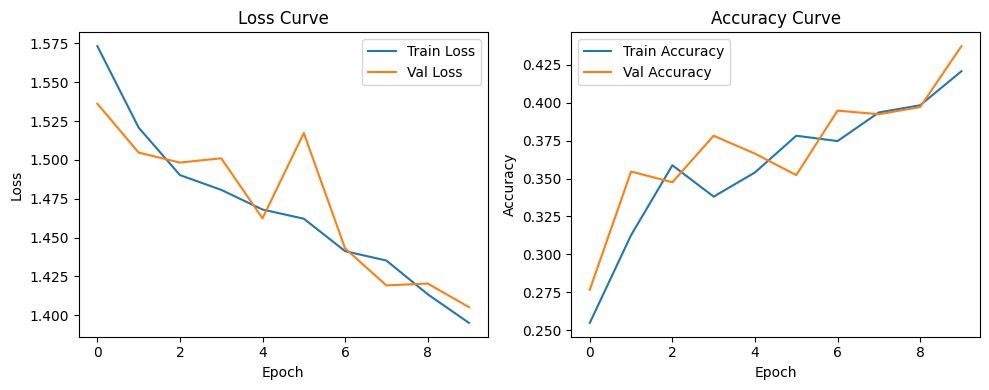

--------------------------------------------------


Fold 2


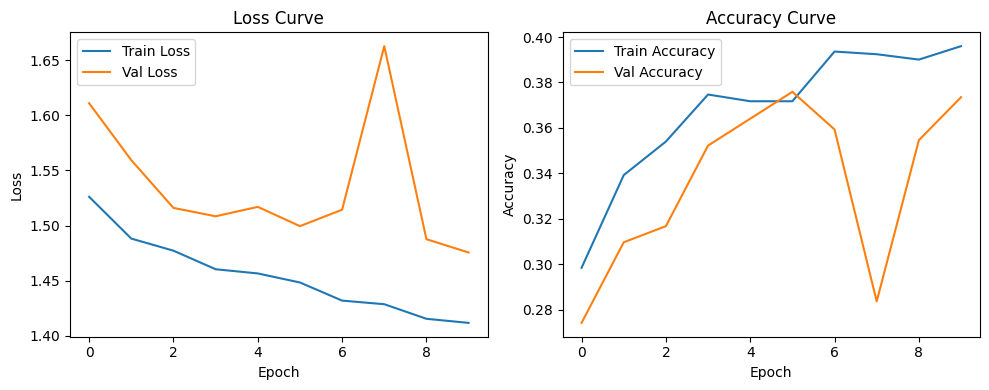

--------------------------------------------------


Fold 3


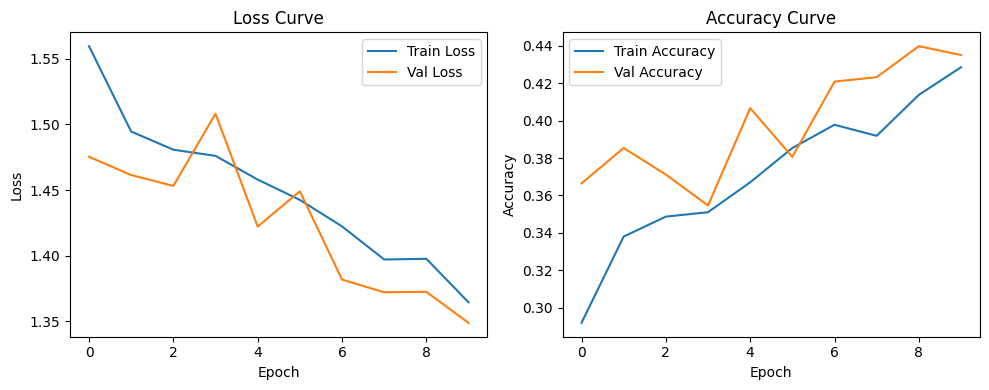

--------------------------------------------------


Fold 4


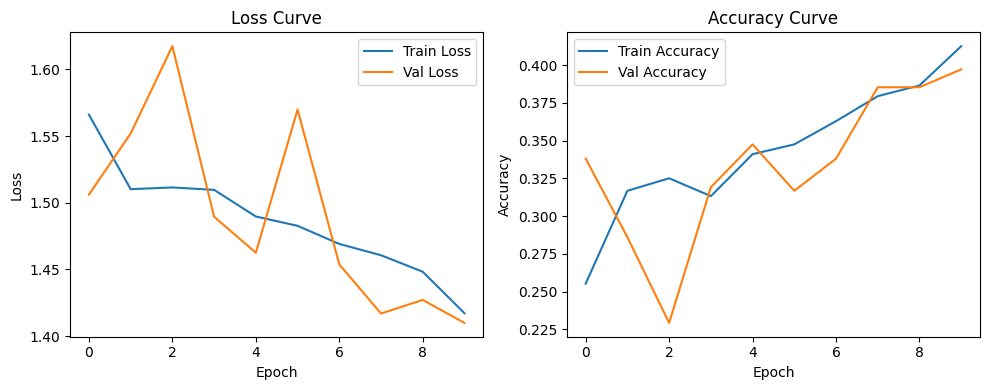

--------------------------------------------------


Fold 5


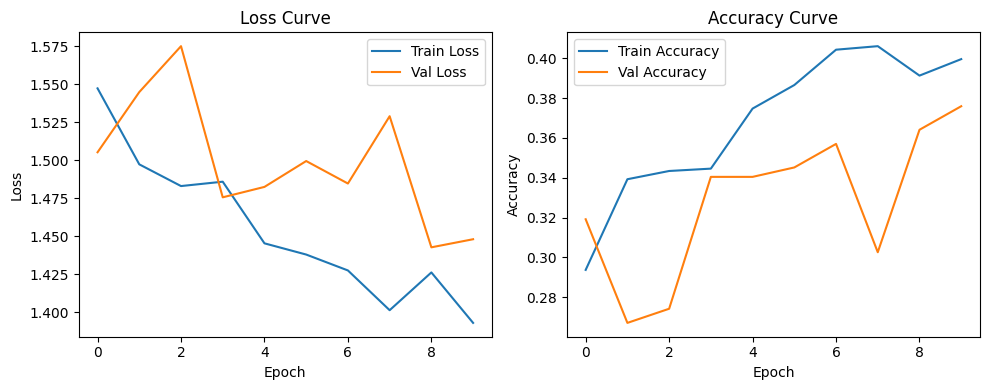

--------------------------------------------------




In [14]:
for fold, (train_losses, val_losses, train_accuracies, val_accuracies) in enumerate(zip(fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies)):
    print(f"Fold {fold+1}")
    plot_acc_loss_curves_train_vs_val(
        train_losses=train_losses, 
        val_losses=val_losses, 
        train_accuracies=train_accuracies, 
        val_accuracies=val_accuracies)
    print("-" * 50)
    print("\n")
    

In [15]:
criterion = torch.nn.CrossEntropyLoss()
test_metrics = evaluate(best_model, test_loader, criterion, prefix='test_')

test_Loss: 1.4348  test_Acc: 0.3814  test_Prec: 0.2208  test_Rec: 0.2884  test_F1: 0.2383  test_ROC-AUC: 0.6605


In [16]:
model_path = "./models/cross_validate_second_model_stratified.pkl"

In [17]:
save_model(best_model, model_path)

In [ ]:
best_model = load_model(model_path)

In [18]:
images, trues, preds = predict(best_model, test_loader)

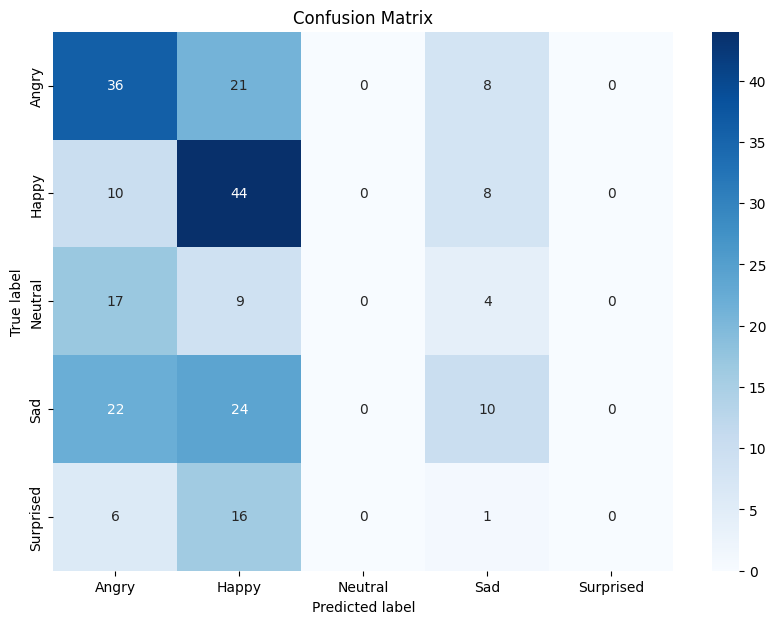

              precision    recall  f1-score   support

       Angry       0.40      0.55      0.46        65
       Happy       0.39      0.71      0.50        62
     Neutral       0.00      0.00      0.00        30
         Sad       0.32      0.18      0.23        56
   Surprised       0.00      0.00      0.00        23

    accuracy                           0.38       236
   macro avg       0.22      0.29      0.24       236
weighted avg       0.29      0.38      0.31       236



c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
classes = list(label_to_index.keys())
plot_conf_mtrx(y_true=trues, y_pred=preds, classes=classes)

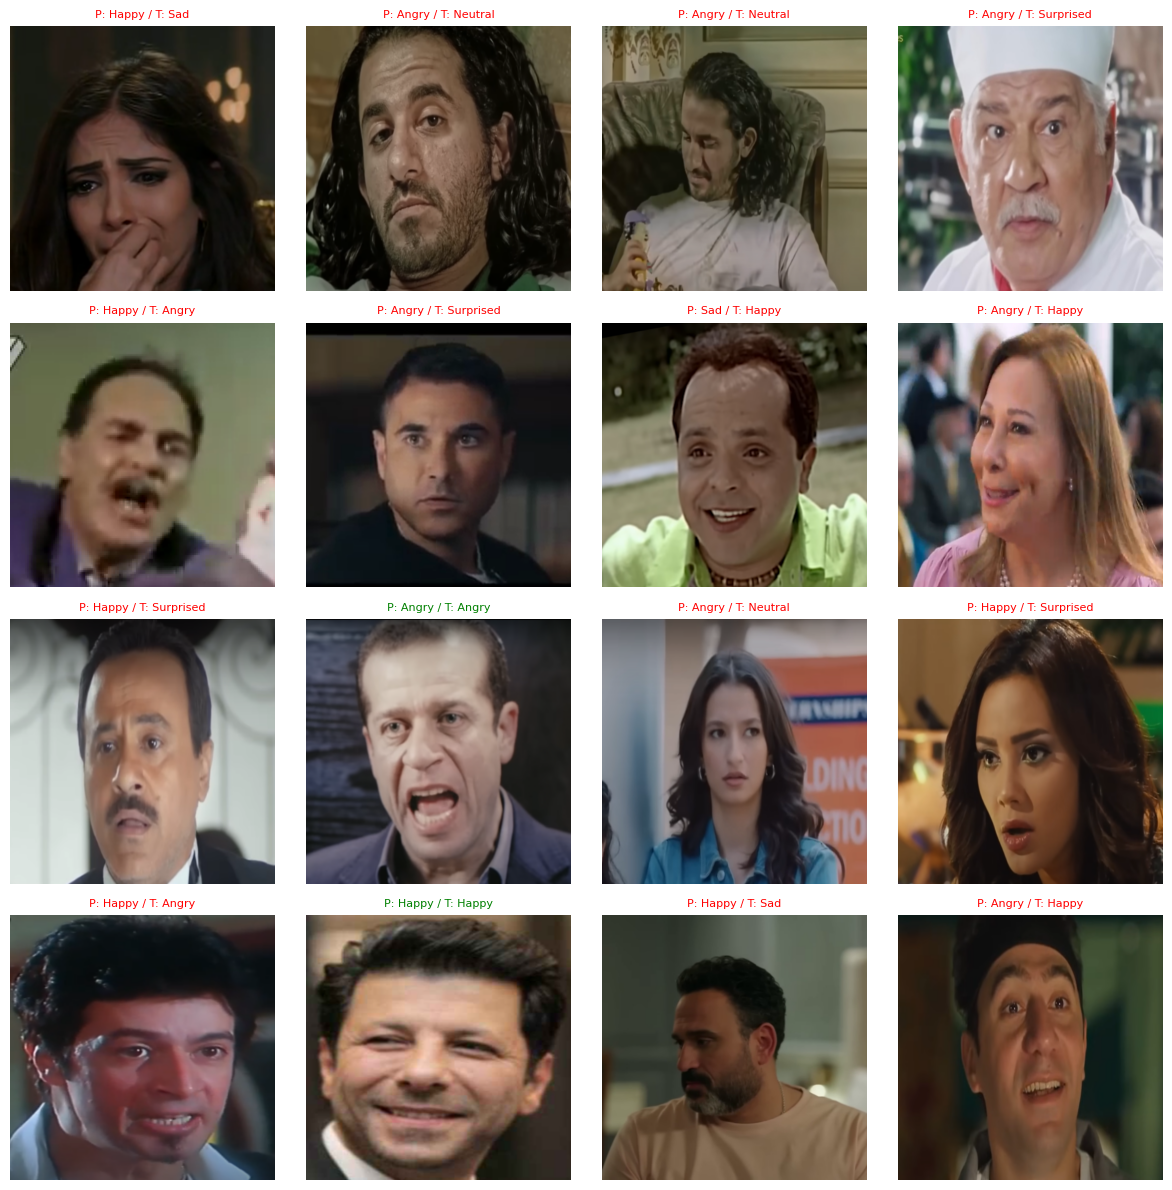

In [20]:
plot_predictions(images, trues, preds, index_to_label, num_images=16, nrow=4)